# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

## Libraries and Dependencies

In [106]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
%matplotlib inline
np.random.seed(1234)

In [107]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Device is ', device)

Device is  cpu


## Physics-informed Neural Networks

In [108]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [109]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, input_data, X_f, layers, lb, ub, nu, alpha):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.y_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.y_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u   = torch.tensor(input_data).float().to(device)
        
        self.layers = layers
        self.nu = nu
        self.alpha = alpha
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=0.005, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        
    def net_u(self, x, y):                   ### Output is 3 columns one of each corresponding to u,v,w
        u = self.dnn(torch.cat([x, y], dim=1))
        return u
    
    def net_f(self, x, y):
        """ The pytorch autograd version of calculating residual """
        output = self.net_u(x, y)
 
        u = output[:,0:1]
        v = output[:,1:2]   ## Scaling the vertical velocity here itself
        p = output[:,-1:]
                
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), retain_graph=True, create_graph=True)[0]
        
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), retain_graph=True, create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), retain_graph=True, create_graph=True)[0]
        
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]
        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]
        
        f = torch.zeros([np.size(x,0), 3], dtype=torch.float)
        
        f[:,0:1] = u * u_x + v*u_y + p_x - self.nu * (u_xx + u_yy)
        f[:,1:2] = (u * v_x + v*v_y + p_y - self.nu * (v_xx + v_yy))*self.alpha
        f[:,-1:] = u_x + v_y
        
        return f
    
    def loss_func(self):
        
        self.optimizer.zero_grad()        
        u_pred = self.net_u(self.x_u, self.y_u)
        f_pred = self.net_f(self.x_f, self.y_f)
        
        loss_u = torch.mean((self.u[:,0:1] - u_pred[:,0:1]) ** 2) + \
                 torch.mean(self.alpha ** 2 * (self.u[:,1:2] - u_pred[:,1:2]) ** 2) + \
                 torch.mean((self.u[:,-1:] - u_pred[:,-1:]) ** 2) 
        loss_f = torch.mean(f_pred ** 2)
        loss = loss_u + loss_f
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print('Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item()))
        return loss
    
    def train(self):
        self.dnn.train()                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        y = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.dnn.eval()
        output = self.net_u(x, y)
        f = self.net_f(x, y)
        output = output.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return output, f

## Configurations

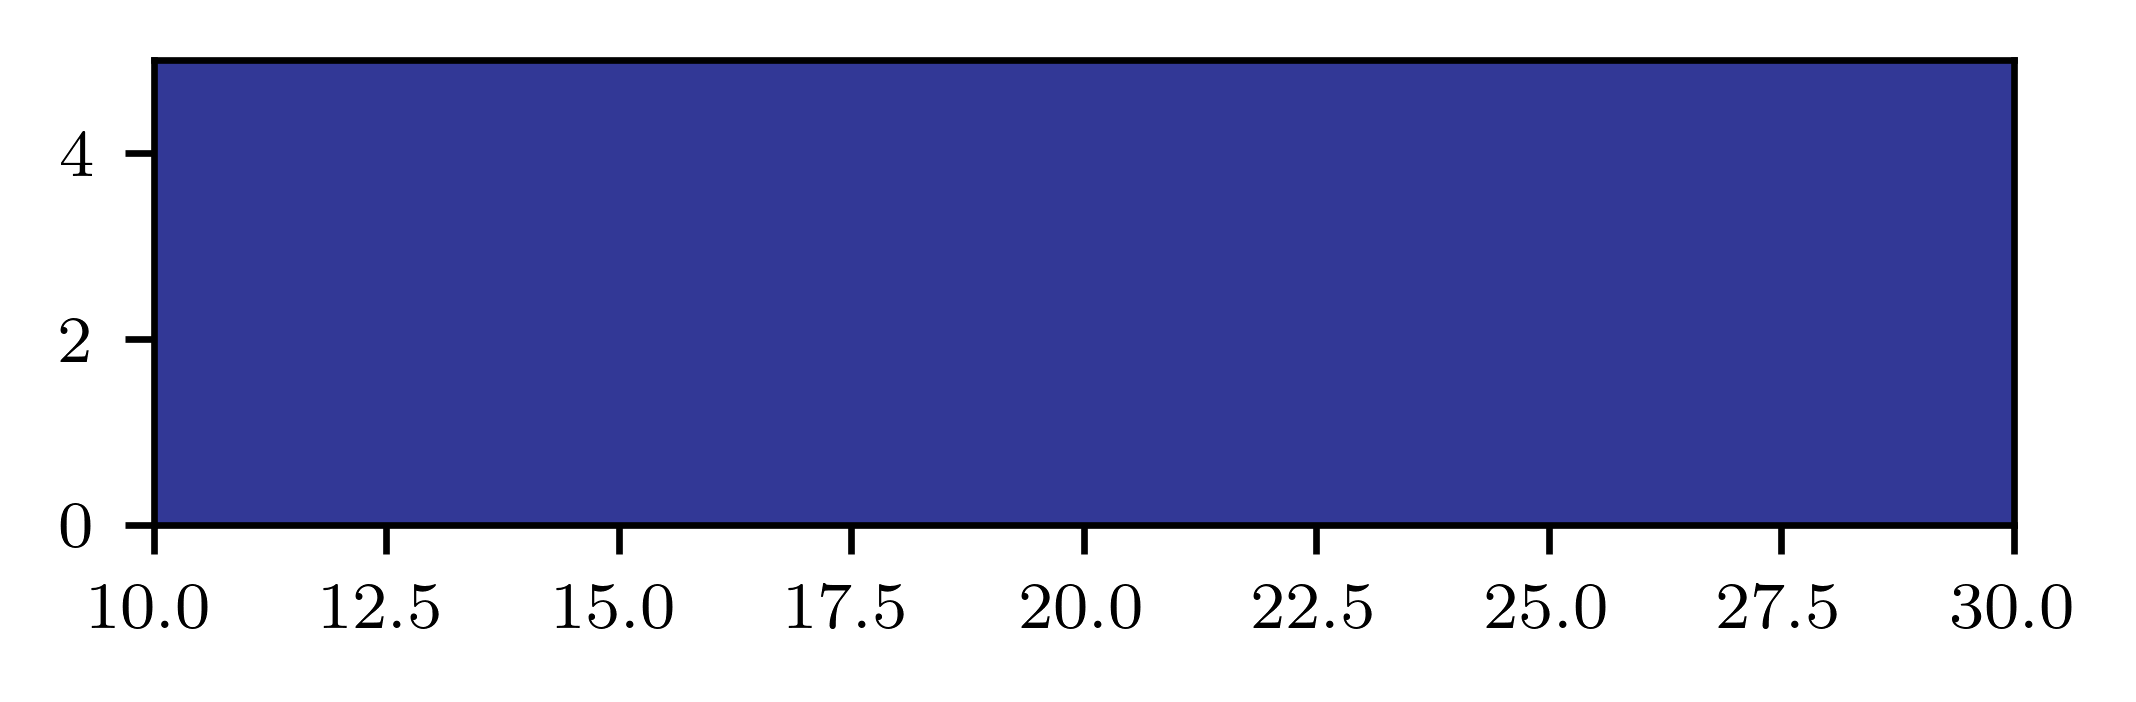

In [110]:
### Dataset and parameter for the Blasius BL

data     = scipy.io.loadmat('./BlasiusBLField.mat')
Xgrid    = data['Xgrid']
Ygrid    = data['Ygrid']
U        = data['U']
V        = data['V']
P        = data['P']
Y        = data['Ygrid'].flatten()[:,None]
X        = data['Xgrid'].flatten()[:,None]
Ustar    = data['U'].flatten()[:,None]
Vstar    = data['V'].flatten()[:,None]
Pstar    = data['P'].flatten()[:,None]
L = 20
Re = 100
nu = L/Re

fig = plt.figure(figsize=(4,2.2), dpi=600)
gsp = gridspec.GridSpec(1,1)
ax0 = plt.subplot(gsp[0,0])
lvls = np.linspace(0,1,100)
cs0 = ax0.contourf(Xgrid, Ygrid, P, levels=lvls, cmap='RdYlBu', extend = 'both')
ax0.set_aspect("equal")

In [111]:
###### Number of points to calculate the MSE and residual on and the number of layers in the network
N_u = 500
N_f = 10000           # Reduce the number of points
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 3]    ## x and y goes in input and U,V,P come in output

##### Flattening the 2D array into a row vector
X_star = np.hstack((Xgrid.flatten()[:,None], Ygrid.flatten()[:,None]))
u_star = U.flatten()[:,None]              
v_star = V.flatten()[:,None]              
p_star = P.flatten()[:,None]

# Doman bounds
lb = X_star.min(0)   ## Min of X and Y
ub = X_star.max(0)   ## Max of X and Y

xx1 = np.hstack((Xgrid[0:1,:].T, Ygrid[0:1,:].T))    ### Bottom horizontal boundary
uu1 = U[0:1,:].T
vv1 = V[0:1,:].T
pp1 = P[0:1,:].T

xx2 = np.hstack((Xgrid[-1:,:].T, Ygrid[-1:,:].T))    ### Top horizontal boundary
uu2 = U[-1:,:].T
vv2 = V[-1:,:].T
pp2 = P[-1:,:].T

xx3 = np.hstack((Xgrid[:,0:1], Ygrid[:,0:1]))       ### Left vertical boundary
uu3 = U[:,0:1]
vv3 = V[:,0:1]
pp3 = P[:,0:1]

xx4 = np.hstack((Xgrid[:,-1:], Ygrid[:,-1:]))      ### Right vertical boundary
uu4 = U[:,-1:]
vv4 = V[:,-1:]
pp4 = P[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3, xx4])        ### Arranging all the coordinates and variables for training
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train   = np.vstack([uu1, uu2, uu3, uu4])
v_train   = np.vstack([vv1, vv2, vv3, vv4])
p_train   = np.vstack([pp1, pp2, pp3, pp4])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)  #### Subset of boundary points to train the ML
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]
v_train = v_train[idx,:]
p_train = p_train[idx,:]
input_data = np.hstack([u_train, v_train, p_train])

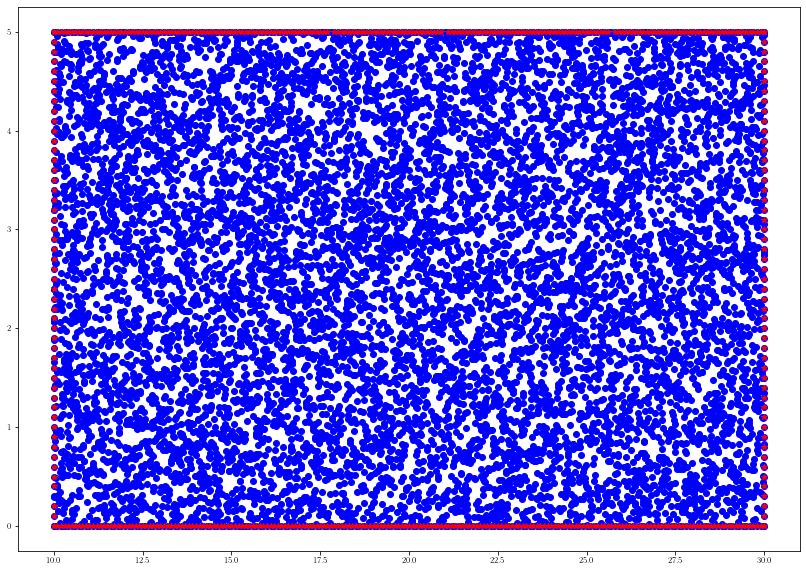

In [112]:
## Visualizing the training points used for the residual and boundary

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax.plot(X_f_train[:,0], X_f_train[:,1], 'bo')  
ax.plot(X_u_train[:,0], X_u_train[:,1], 'r*')  

## Training

In [113]:
model = PhysicsInformedNN(X_u_train, input_data, X_f_train, layers, lb, ub, nu, 10)

In [114]:
%%time

model.train()

Iter 100, Loss: 2.53246e-01, Loss_u: 2.53014e-01, Loss_f: 2.32003e-04
Iter 200, Loss: 1.79694e-02, Loss_u: 1.72776e-02, Loss_f: 6.91820e-04
Iter 300, Loss: 1.16582e-02, Loss_u: 1.13282e-02, Loss_f: 3.29980e-04
Iter 400, Loss: 4.44474e-03, Loss_u: 3.69662e-03, Loss_f: 7.48126e-04
Iter 500, Loss: 3.88192e-03, Loss_u: 3.31135e-03, Loss_f: 5.70566e-04
Iter 600, Loss: 3.47734e-03, Loss_u: 2.85000e-03, Loss_f: 6.27336e-04
Iter 700, Loss: 2.83771e-03, Loss_u: 2.53407e-03, Loss_f: 3.03640e-04
Iter 800, Loss: 1.79252e-03, Loss_u: 1.60308e-03, Loss_f: 1.89448e-04
Iter 900, Loss: 1.22454e-03, Loss_u: 9.30467e-04, Loss_f: 2.94078e-04
Iter 1000, Loss: 9.18427e-04, Loss_u: 6.39836e-04, Loss_f: 2.78591e-04
Iter 1100, Loss: 8.31661e-04, Loss_u: 5.29104e-04, Loss_f: 3.02557e-04
Iter 1200, Loss: 7.93990e-04, Loss_u: 4.27856e-04, Loss_f: 3.66134e-04
Iter 1300, Loss: 6.73416e-04, Loss_u: 3.15027e-04, Loss_f: 3.58389e-04
Iter 1400, Loss: 5.09074e-04, Loss_u: 1.98148e-04, Loss_f: 3.10926e-04
Iter 1500, Loss

In [115]:
output_pred, f_pred = model.predict(X_star)
output_u, f_u = model.predict(X_u_train)

Upred = output_pred[:,0:1]
Vpred = output_pred[:,1:2]
Ppred = output_pred[:,2:]

Uu = output_u[:,0:1]
Vu = output_u[:,1:2]
Pu = output_u[:,2:]

tot_error_predicted = np.mean((Uu-u_train)**2) + 100*np.mean((Vu-v_train)**2) + np.mean((Pu-p_train)**2)

print('Residual f predicted: %e' % np.mean(f_pred**2))
print('Total error predicted: %e' % tot_error_predicted)

error_u = np.linalg.norm(Ustar-Upred,2)/np.linalg.norm(Ustar,2)*100
print('Error u: %e' % (error_u))                     

error_v = np.linalg.norm(Vstar-Vpred,2)/np.linalg.norm(Vstar,2)*100
print('Error v: %e' % (error_v))

error_p = np.linalg.norm(Pstar-Ppred,2)/np.linalg.norm(Pstar,2)*100
print('Error p: %e' % (error_p))

Upred = griddata(X_star, Upred.flatten(), (X, Y), method='cubic')
Ugrid =  np.reshape(Upred, [np.size(Xgrid,0), np.size(Xgrid,1)])

Vpred = griddata(X_star, Vpred.flatten(), (X, Y), method='cubic')
Vgrid =  np.reshape(Vpred, [np.size(Xgrid,0), np.size(Xgrid,1)])

Ppred = griddata(X_star, Ppred.flatten(), (X, Y), method='cubic')
Pgrid =  np.reshape(Ppred, [np.size(Xgrid,0), np.size(Xgrid,1)])

Residual f predicted: 1.827536e-04
Total error predicted: 7.069083e-05
Error u: 2.546309e+00
Error v: 3.760588e+00
Error p: 3.368998e-01


## Visualizations

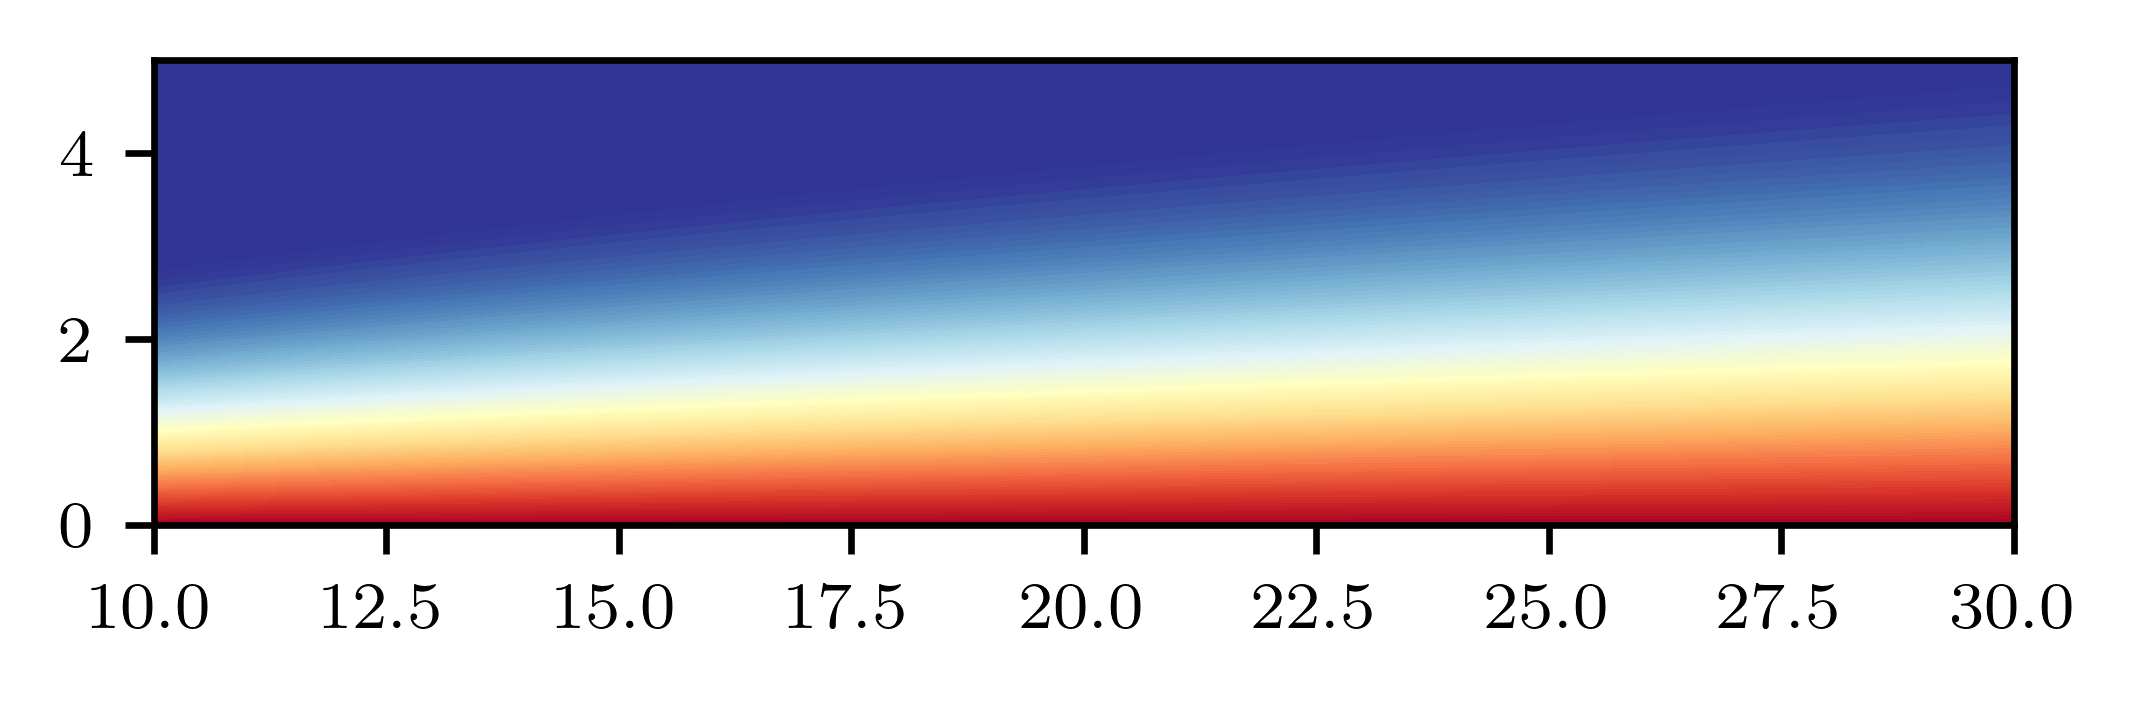

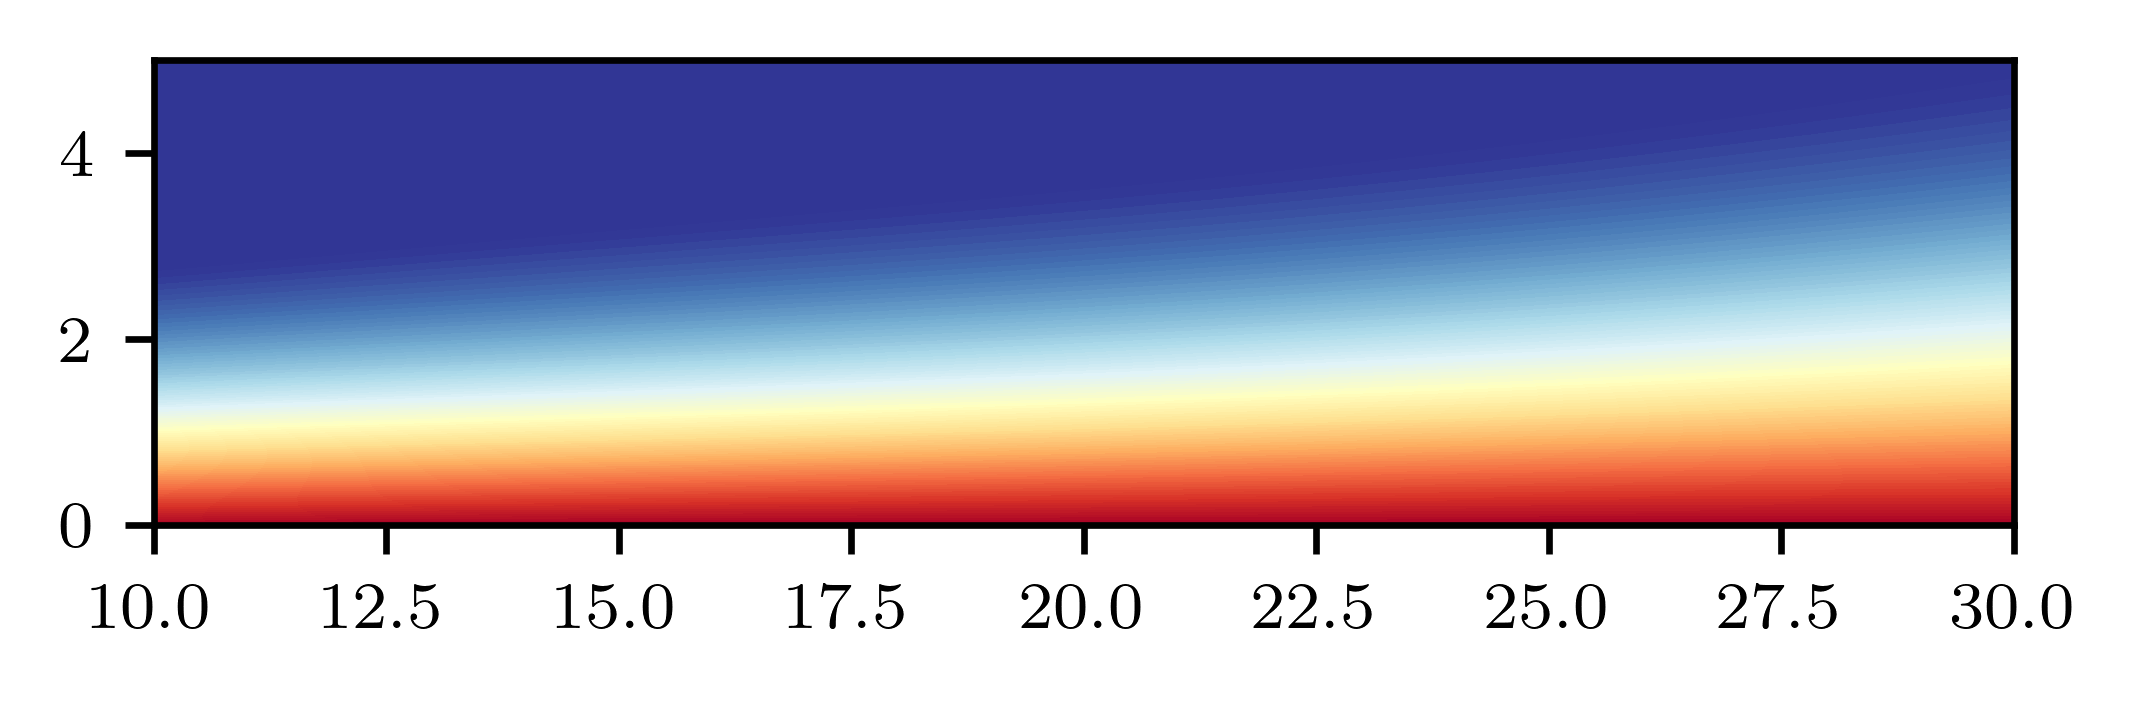

In [116]:

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(4,2.2), dpi=600)
gsp = gridspec.GridSpec(1,1)
ax0 = plt.subplot(gsp[0,0])
lvls = np.linspace(0,1,100)
cs0 = ax0.contourf(Xgrid, Ygrid, U, levels=lvls, cmap='RdYlBu', extend = 'both')
ax0.set_aspect("equal")

fig = plt.figure(figsize=(4,2.2), dpi=600)
gsp = gridspec.GridSpec(1,1)
ax0 = plt.subplot(gsp[0,0])
lvls = np.linspace(0,1,100)
cs0 = ax0.contourf(Xgrid, Ygrid, Ugrid, levels=lvls, cmap='RdYlBu', extend = 'both')
ax0.set_aspect("equal")

Location  20.1


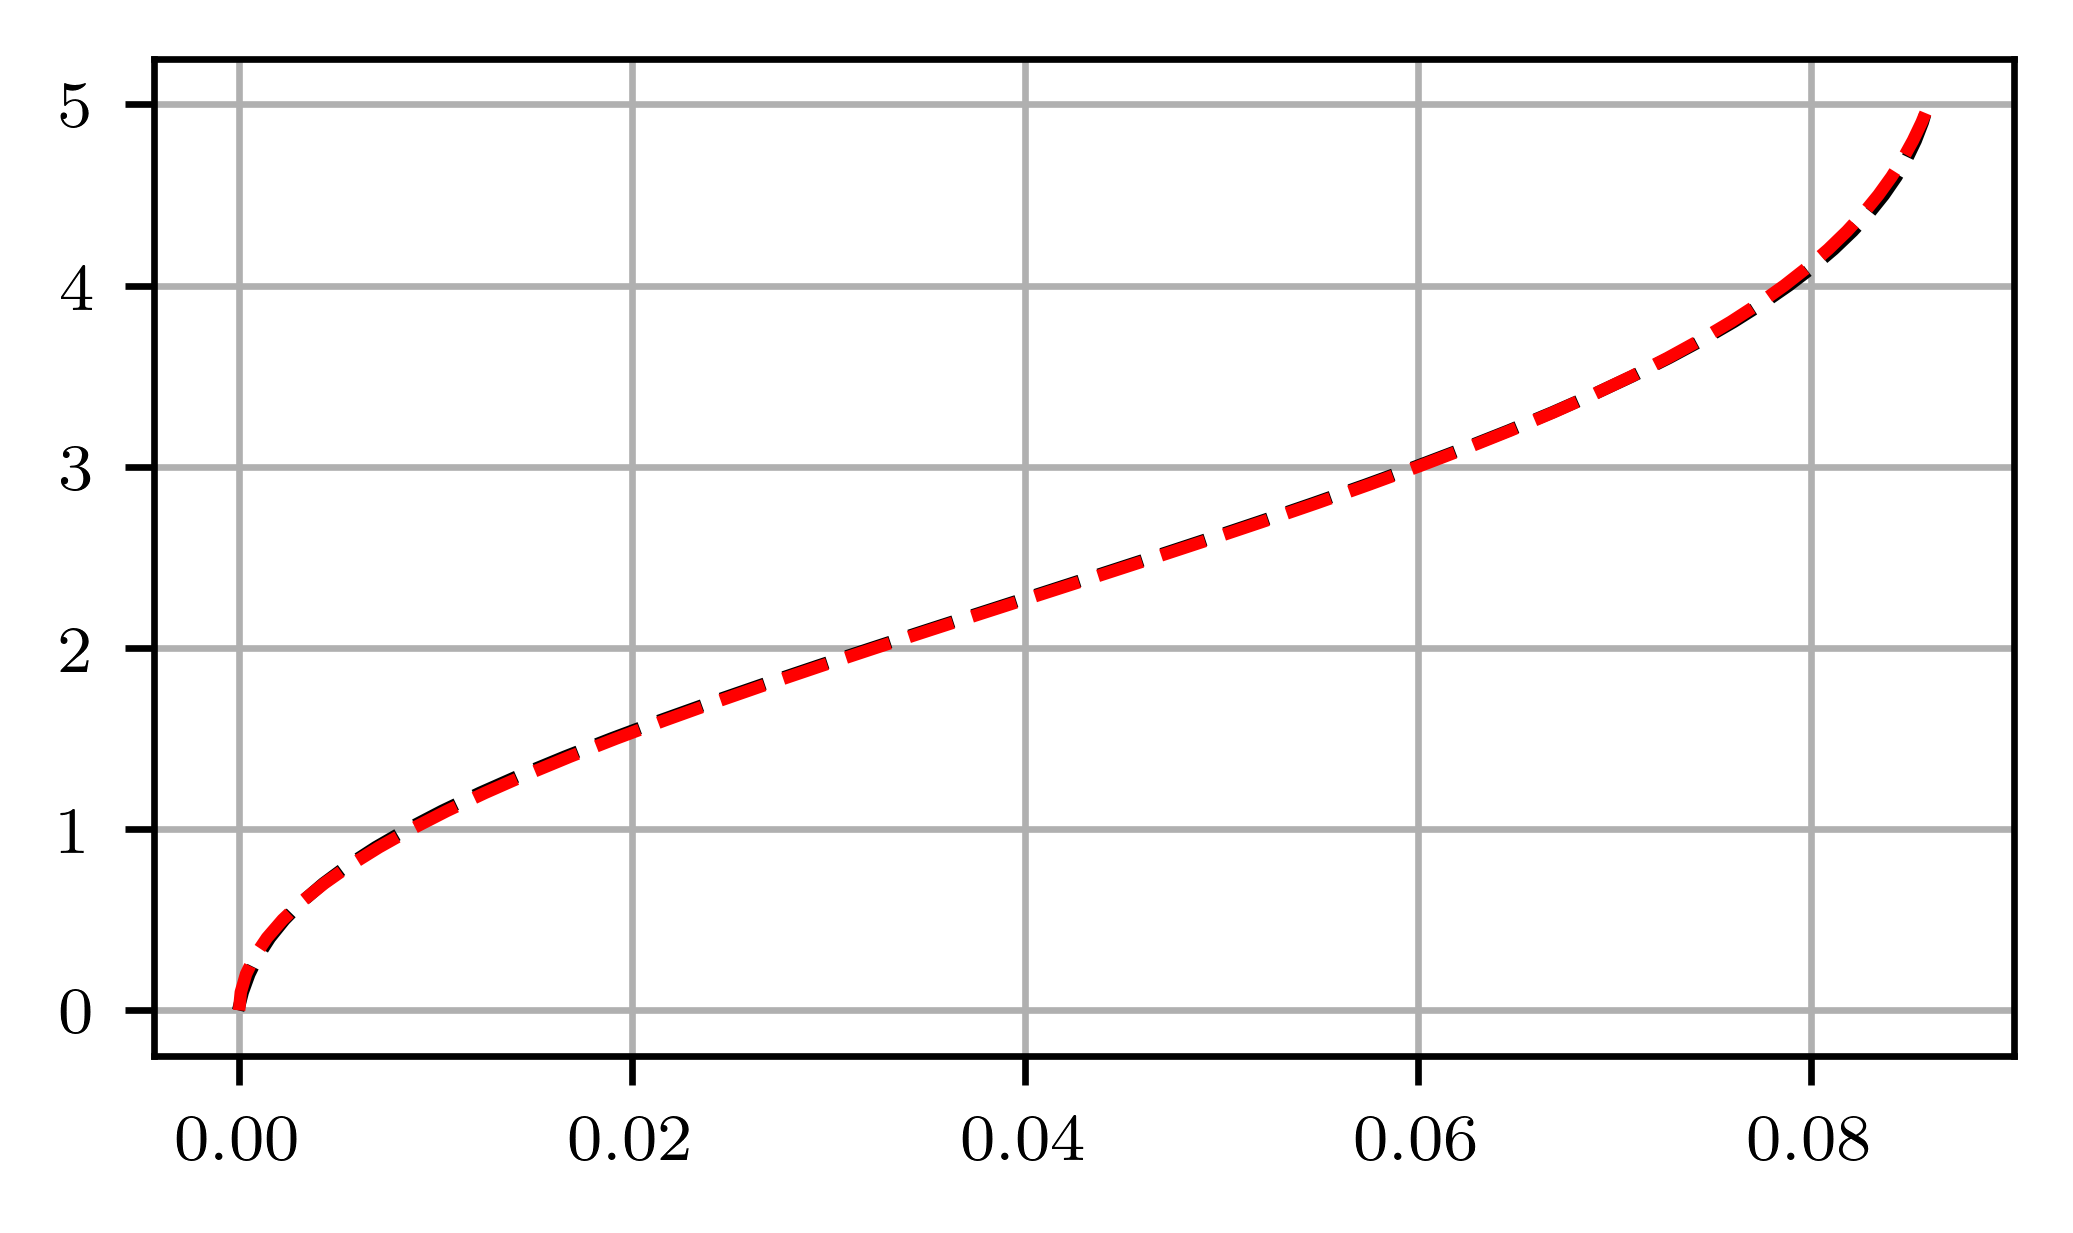

In [105]:
idx = -100
print('Location ', Xgrid[50,idx])
fig = plt.figure(figsize=(4,2.2), dpi=600)
gsp = gridspec.GridSpec(1,1)
ax0 = plt.subplot(gsp[0,0])
cs0 = plt.plot(Vgrid[:,idx], Ygrid[:,idx],'k--')
cs1 = plt.plot(V[:,idx], Ygrid[:,idx],'r--')
plt.grid()
plt.show()

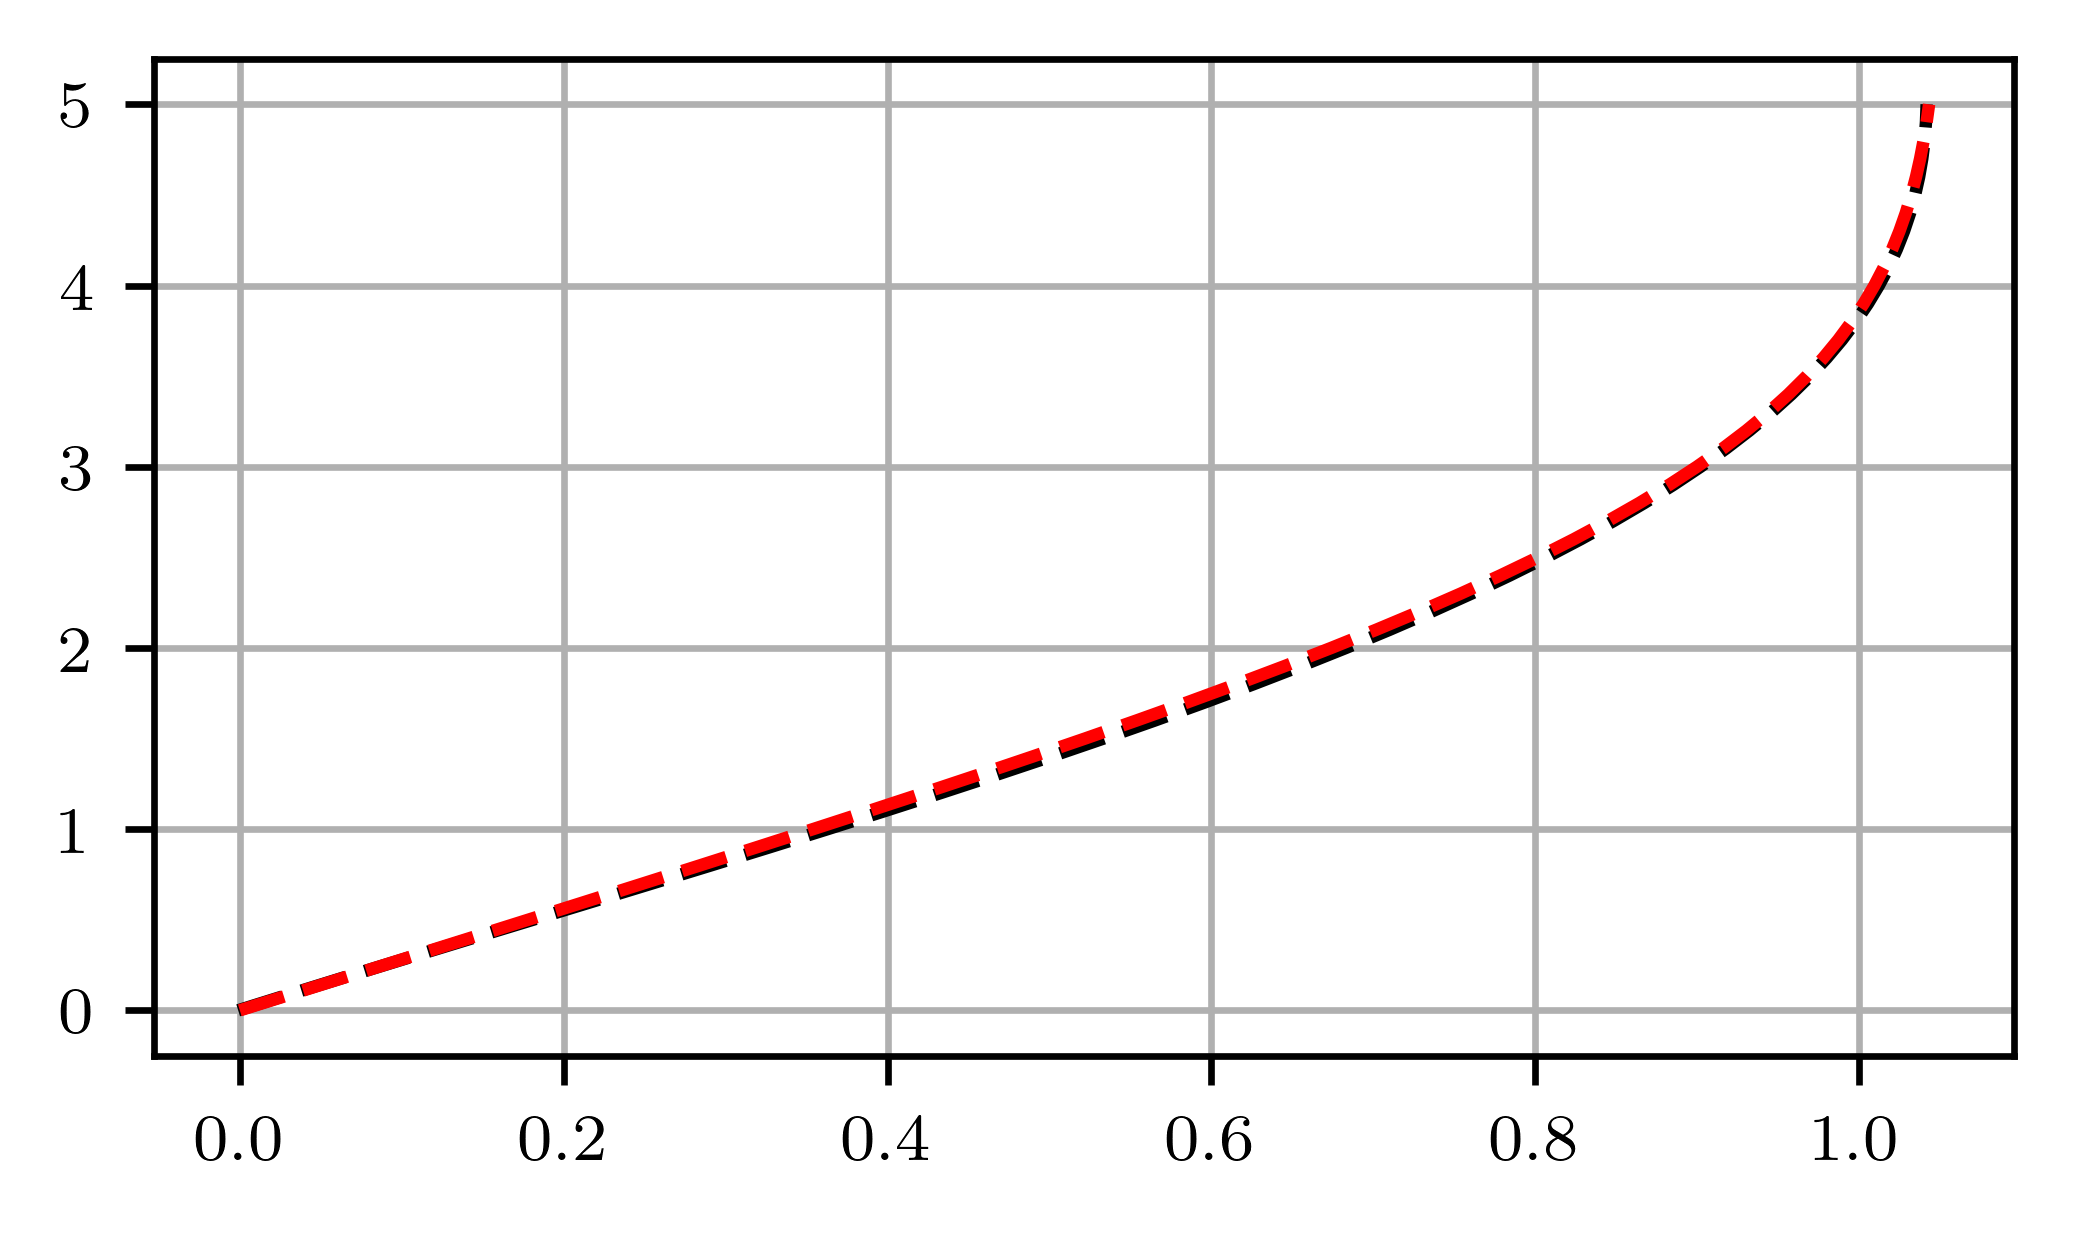

In [104]:
idx = -100
fig = plt.figure(figsize=(4,2.2), dpi=600)
gsp = gridspec.GridSpec(1,1)
ax0 = plt.subplot(gsp[0,0])
cs0 = plt.plot( Ugrid[:,idx], Ygrid[:,idx],'k--')
cs1 = plt.plot(U[:,idx], Ygrid[:,idx],'r--')
plt.grid()
plt.show()